In [61]:
import pandas as pd
import numpy as np
import os
import datetime
from dtaidistance import dtw
from dtaidistance import clustering
import simplejson
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list
from matplotlib import pyplot as plt


In [50]:
import git
import sys
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [51]:
with open('NYT_daily_Warp_Death.txt') as f:
    NYT_daily_Warp_Death = simplejson.load(f)
with open('NYT_daily_Death_Filled.txt') as g:
    NYT_daily_Death_Filled = simplejson.load(g)
with open('JHU_daily_death.txt') as h:
    JHU_daily_death = simplejson.load(h)

In [52]:
def znormalize(ls):
#normalizes a list, if std=0 return the list
    std = np.std(ls)
    if std == 0.0:
        return np.array(ls)
    else:
        val = (ls - np.mean(ls))/np.std(ls)
        return (ls - np.mean(ls))/np.std(ls)

In [53]:
def znormalize_nozeros(ls):
#normalizes a list, if std=0 just pass
    std = np.std(ls)
    if std == 0.0:
        pass
    else:
        return (ls - np.mean(ls))/np.std(ls)

In [54]:
def noinf(arr):
    #Removes inf from list of lists
    newarr = []
    for x in arr:
        temp = x
        temp[temp == np.inf] = 9999
        newarr.append(x)
    return newarr

In [55]:
def nonzerofips(arr):
    #Takes in dataset, returns indices of data that do not have a list with all 0's
    ind = []
    for i in range(len(arr)):
        if np.std(arr[i]) != 0:
            ind.append(i)
    return ind

In [56]:
#Z normalization of our dataset
Series_NYT_W = [znormalize(x) for x in NYT_daily_Warp_Death]
Series_NYT_F = [znormalize(x) for x in NYT_daily_Death_Filled]
Series_JHU = [znormalize(x) for x in JHU_daily_death]

In [57]:
#Removal of Strictly 0 lists from our dataset, these will belong in cluster 0
Series_NYT_W_nozeros = [znormalize_nozeros(x) for x in NYT_daily_Warp_Death]
Series_NYT_W_nozeros =  [x for x in Series_NYT_W_nozeros if x is not None]

Series_NYT_F_nozeros = [znormalize_nozeros(x) for x in NYT_daily_Death_Filled]
Series_NYT_F_nozeros =  [x for x in Series_NYT_F_nozeros if x is not None]

Series_JHU_nozeros = [znormalize_nozeros(x) for x in JHU_daily_death]
Series_JHU_nozeros =  [x for x in Series_JHU_nozeros if x is not None]

In [58]:
#we choose this dataset to do examples because it is the most "regular", as it has 
#the same starting and end dates for each fips codes, of 3/23/20, and having the same end date
Series_JHU

[array([-0.26726124, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
        -0.26726124, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
        -0.26726124, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
         3.74165739, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
        -0.26726124, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
        -0.26726124, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
         3.74165739, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
         3.74165739, -0.26726124, -0.26726124, -0.26726124, -0.26726124,
        -0.26726124, -0.26726124, -0.26726124, -0.26726124, -0.26726124]),
 array([-0.35355339, -0.35355339, -0.35355339, -0.35355339, -0.35355339,
        -0.35355339,  2.82842712, -0.35355339, -0.35355339, -0.35355339,
        -0.35355339, -0.35355339, -0.35355339, -0.35355339, -0.35355339,
        -0.35355339, -0.35355339, -0.35355339, -0.35355339, -0.35355339,
        -0.35355339, -0.35355339,  2.82842712, -0

In [59]:
#This is supposed to be a clustering based on using DTAIDistance, which is a library that can first do DTW distance 
#Calcultaions between time series, and from that create a hierarchical clustering
#This is a small example, check the Big file for all the cases
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(Series_JHU)
#It seems like no clustering occurs, check doculmentation for DTAIdistance

In [66]:
cluster_idx

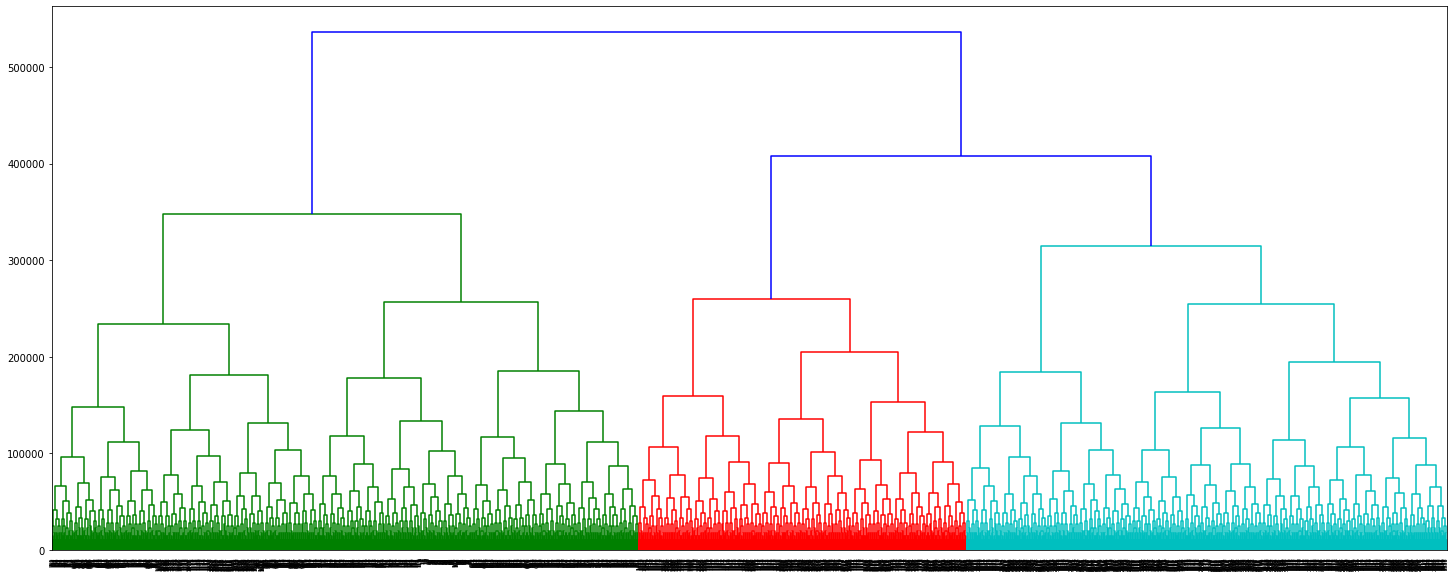

In [62]:
#This is an example of trying to first do the DTW distance matrix creation
#Using simple the time series data, gives distance matrix
distance_JHU = dtw.distance_matrix_fast(Series_JHU)
#one large issue i am having with this is that this distance matrix is not symmetric, so idk how to pass it into 
#another hierachical clustering function because i cant find one that takes a non symmetric distance matrix

#This takes the distance matrrix and does scipy hierachical clustering
#But this is actually wrong because linkage takes in a flattened distance array or a 2-d array of observation vectors, not 
# a 2d distance matrix
Z_JHU = linkage(noinf(distance_JHU), 'complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU = dendrogram(Z_JHU)
#Shows the dendrogram of the resulting clusetering

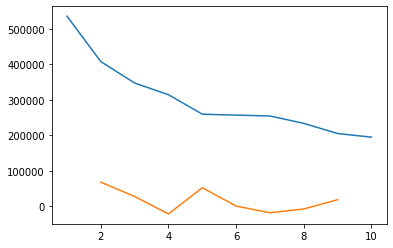

clusters: 2


In [63]:
#This is a plot of the elbow method to help determine what number of clusters should be used
last = Z_JHU[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [64]:
#Clustering ids
clusters_JHU = fcluster(Z_JHU, 5, criterion='maxclust')
#if you try to look at these clusters you see that consecutive fips have all the same cluster
#you get large blocks as the clusters, probably because the distance matrix input in the linkage line is incorrect
